In [1]:
import os
import socket

hostname = socket.gethostname()
if hostname == "lcls-srv04":
    os.environ["OMP_NUM_THREADS"] = str(1)
elif hostname == "test-rhel7":
    os.environ["OMP_NUM_THREADS"] = str(6)

In [2]:
import sys
# import warnings
# warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import pandas as pd
import torch

from xopt import Xopt, VOCS
from xopt.evaluator import Evaluator
from xopt.numerical_optimizer import LBFGSOptimizer
from xopt.generators.bayesian import ExpectedImprovementGenerator
from xopt.generators.bayesian.models.standard import StandardModelConstructor

sys.path.append("calibration/calibration_modules/")
from decoupled_linear import OutputOffset, DecoupledLinearOutput
from utils import load_model, get_model_predictions, get_running_optimum

## Define VOCS

In [3]:
variables = ["SOLN:IN20:121:BCTRL", "QUAD:IN20:121:BCTRL"]
# variables = [
#     "SOLN:IN20:121:BCTRL", "QUAD:IN20:121:BCTRL", "QUAD:IN20:122:BCTRL",
#     "QUAD:IN20:361:BCTRL", "QUAD:IN20:371:BCTRL", "QUAD:IN20:425:BCTRL",
#     "QUAD:IN20:441:BCTRL", "QUAD:IN20:511:BCTRL", "QUAD:IN20:525:BCTRL",
# ]

filename = "../variables.csv"
variable_ranges = pd.read_csv(filename, index_col=0, header=None).T.to_dict(orient='list')
vocs = VOCS(
    variables = {ele: variable_ranges[ele] for ele in variables},
    objectives = {"total_size": "MINIMIZE"},
    constraints = {"c1": ["LESS_THAN", 0.0]},
)
print(vocs.as_yaml())

variables:
  SOLN:IN20:121:BCTRL: [0.377, 0.498]
  QUAD:IN20:121:BCTRL: [-0.021, 0.021]
constraints:
  c1: [LESS_THAN, 0.0]
objectives: {total_size: MINIMIZE}
constants: {}
observables: []



## Define NN prior

In [4]:
objective_model = load_model(
    input_variables=vocs.variable_names,
    model_path="lcls_cu_injector_nn_model/",
)
lume_model = objective_model.model.model

# define miscalibrated objective model
y_size = len(vocs.objective_names)
miscal_model = DecoupledLinearOutput(
    model=objective_model,
    y_offset_initial=torch.full((y_size,), -0.5),
    y_scale_initial=torch.ones(y_size),
)
miscal_model.requires_grad_(False);

# define prior mean
prior_mean = OutputOffset(
    model=miscal_model,
)

## Define evaluate function

In [5]:
# Xopt evaluator function
def evaluate(input_dict, generator=None, noise_level=0.1):
    model_result = lume_model.evaluate(input_dict)
    objective_value = objective_model.function(
        sigma_x=model_result["OTRS:IN20:571:XRMS"],
        sigma_y=model_result["OTRS:IN20:571:YRMS"],
    )
    noise = torch.normal(
        mean=torch.zeros(objective_value.shape),
        std=noise_level * torch.ones(objective_value.shape),
    )
    v = objective_value + noise
    output_dict = {vocs.objective_names[0]: v.detach().item()}
    
    # dummy constraint
    output_dict["c1"] = output_dict[vocs.objective_names[0]] - 1.0

    # GP model predictions
    model_predictions = get_model_predictions(input_dict, generator)
    output_dict.update(model_predictions)
    
    return output_dict

## Adjust variable ranges

In [6]:
vocs.variables = {
    k: lume_model.input_variables[lume_model.input_names.index(k)].value_range 
    for k in vocs.variable_names
}
vocs.variables["SOLN:IN20:121:BCTRL"] = [0.467, 0.479]
print(vocs.as_yaml())

variables:
  QUAD:IN20:121:BCTRL: [-0.02098429469554406, 0.020999198106589838]
  SOLN:IN20:121:BCTRL: [0.467, 0.479]
constraints:
  c1: [LESS_THAN, 0.0]
objectives: {total_size: MINIMIZE}
constants: {}
observables: []



## Run Xopt

In [7]:
# remember to set use low noise prior to false!!!
gp_constructor = StandardModelConstructor(
    use_low_noise_prior=False,
    mean_modules={vocs.objective_names[0]: prior_mean},
    trainable_mean_keys=[vocs.objective_names[0]],
)
generator = ExpectedImprovementGenerator(
    vocs=vocs,
    gp_constructor=gp_constructor,
)
generator.numerical_optimizer.max_iter = 200
evaluator = Evaluator(function=evaluate, function_kwargs={"generator": None})
X = Xopt(generator=generator, evaluator=evaluator, vocs=vocs)

# pass generator to evaluator to compute model predictions
X.evaluator = Evaluator(function=evaluate, function_kwargs={"generator": X.generator})

In [8]:
n_init = 3
X.random_evaluate(n_init, seed=0)

,QUAD:IN20:121:BCTRL,SOLN:IN20:121:BCTRL,total_size,c1,total_size_prior_mean,total_size_posterior_mean,total_size_posterior_sd,c1_prior_mean,c1_posterior_mean,c1_posterior_sd,xopt_runtime,xopt_error
0,-0.005743,0.478802,0.512429,-0.487571,NaN,NaN,NaN,NaN,NaN,NaN,0.001627,False
1,0.009673,0.469241,1.153907,0.153907,NaN,NaN,NaN,NaN,NaN,NaN,0.000445,False
2,0.019279,0.468047,1.441695,0.441695,NaN,NaN,NaN,NaN,NaN,NaN,0.000374,False


In [9]:
%%time
n_step = 50
for i in range(n_step):
    X.step()

CPU times: user 7min 27s, sys: 34.1 s, total: 8min 1s
Wall time: 2min 15s


## Display results

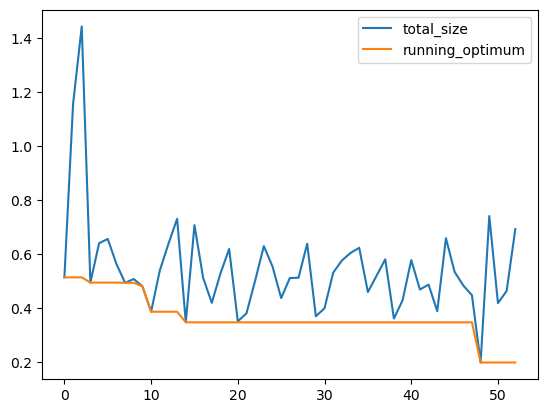

In [10]:
opt = get_running_optimum(
    data=X.data,
    objective_name=X.vocs.objective_names[0],
    maximize=X.vocs.objectives[X.vocs.objective_names[0]].upper() == "MAXIMIZE",
)
ax = X.data.plot(y=X.vocs.objective_names[0])
ax.plot(opt, label="running_optimum")
ax.legend();

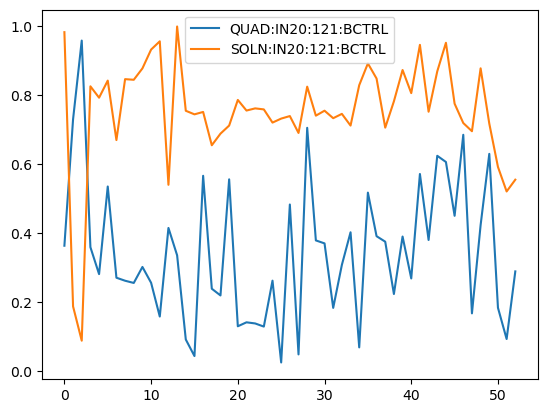

In [11]:
vocs.normalize_inputs(X.data).plot(y=X.vocs.variable_names);

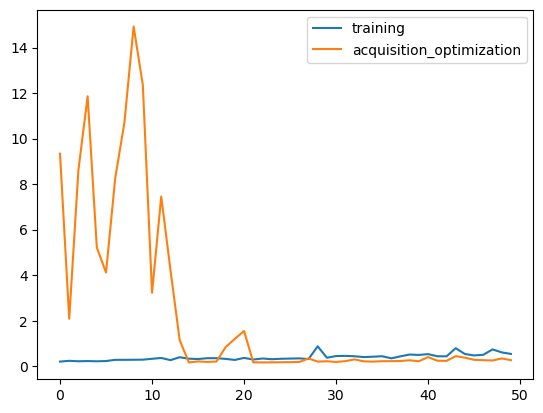

In [12]:
X.generator.computation_time[["training", "acquisition_optimization"]].plot();

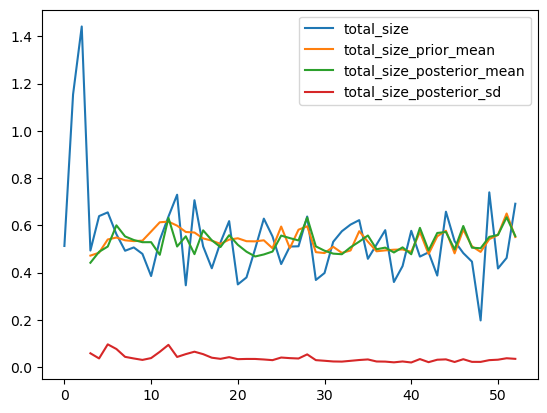

In [13]:
label_suffixes = ["", "_prior_mean", "_posterior_mean", "_posterior_sd"]
X.data[[X.vocs.objective_names[0] + k for k in label_suffixes]].plot();

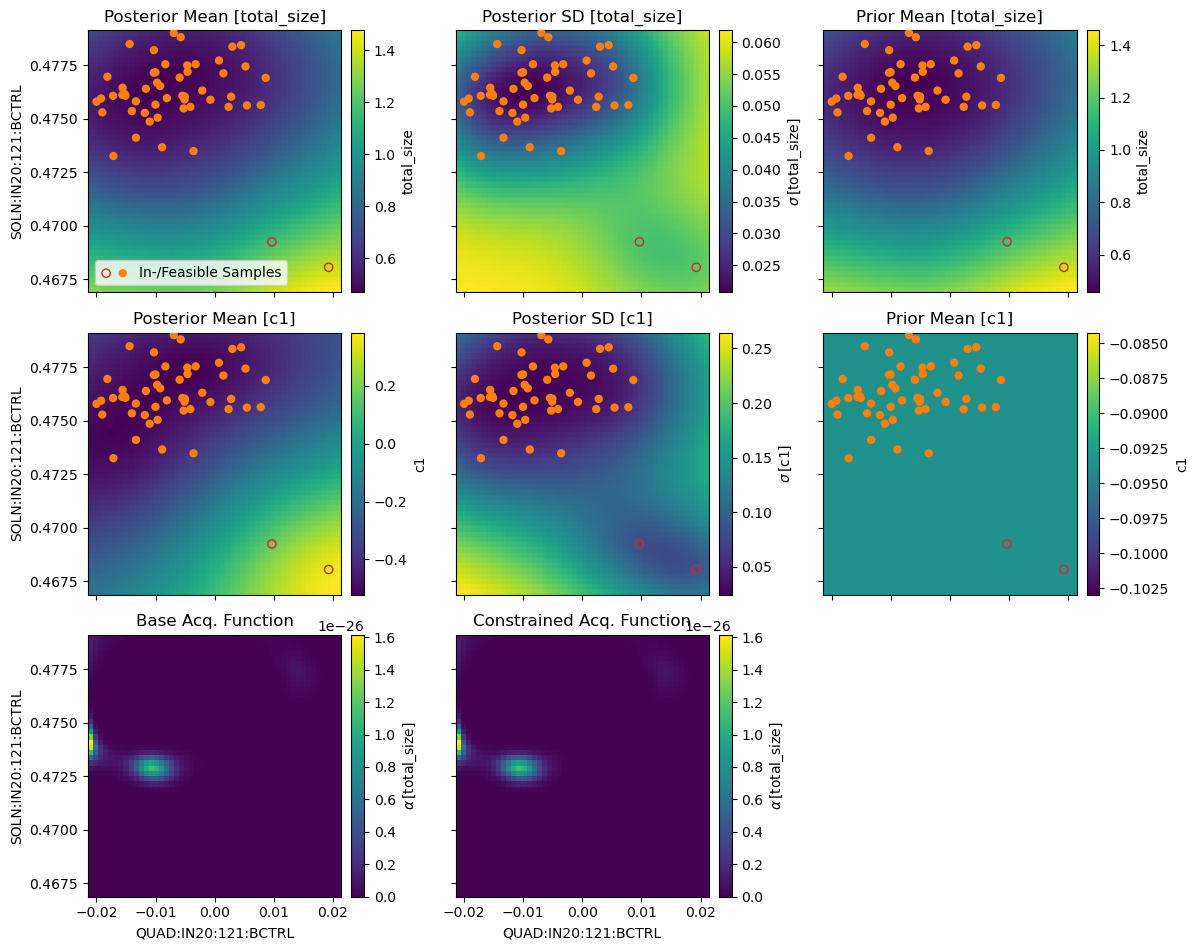

In [14]:
variable_names = X.vocs.variable_names
if X.vocs.n_variables not in [1, 2]:
    variable_names = ["SOLN:IN20:121:BCTRL"]

X.generator.visualize_model(
    variable_names=variable_names,
    show_prior_mean=True,
);

In [15]:
# evaluate output calibration
learned_prior_mean = X.generator.model.models[0].mean_module._model
df = pd.DataFrame(columns=["y_offset", "y_offset_learned", "y_scale", "y_scale_learned"])
for i in range(y_size):
    y_offset = miscal_model.y_offset.detach()[i].item()
    y_offset_learned = torch.nan
    if hasattr(learned_prior_mean, "y_offset"):
        y_offset_learned = -learned_prior_mean.y_offset.detach()[i].item()
    y_scale = miscal_model.y_scale.detach()[i].item()
    y_scale_learned = torch.nan
    if hasattr(learned_prior_mean, "y_scale"):
        y_scale_learned = 1 / learned_prior_mean.y_scale.detach()[i].item()
    df.loc[len(df.index)] = [y_offset, y_offset_learned, y_scale, y_scale_learned]
df

,y_offset,y_offset_learned,y_scale,y_scale_learned
0,-0.5,-0.490463,1.0,NaN
